In [1]:
import torch
import numpy as np
import math
# from diffusers import StableDiffusionInpaintingPipeline
from torchvision.utils import save_image
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import os
from torch.utils.data import DataLoader
from tqdm import tqdm
import sys
sys.path.insert(0, "Image_Inpainting")
from data import InpaintingDataset, find_images_recursively
from evaluate_models import evaluate_model, calculate_psnr
from utils import make_mask
from diffusers import StableDiffusionInpaintPipeline, DiffusionPipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2025-06-10 22:35:39.561794: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-10 22:35:39.561856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-10 22:35:39.563184: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-10 22:35:39.569644: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16
).to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [3]:
def run_inpainting_old(val_loader, save_dir="celeba_filtered_outputs", prompt="", stop_at=5):
    os.makedirs(save_dir, exist_ok=True)
    cnt = 0
    
    for i, (masked_image, img, mask) in enumerate(val_loader):
        cnt += 1
        # print(masked_image.shape, img.shape, mask.shape)
        # result = pipe(prompt=prompt, image=masked_image, mask_image=mask).images[0]
        result = pipe(prompt=prompt, image=img, mask_image=mask).images[0]

        result.save(os.path.join(save_dir, f"inpainted_{i+5:04d}.png"))
        save_image(masked_image[0], os.path.join(save_dir, f"masked_{i+5:04d}.png"))
        save_image(img[0], os.path.join(save_dir, f"original_{i+5:04d}.png"))
        save_image(mask[0], os.path.join(save_dir, f"mask_{i+5:04d}.png"))
        
        # img.save(os.path.join(save_dir, f"original_{i:04d}.png"))

        if i % 10 == 0:
            print(f"[{i}] Inpainted image saved.")

        if cnt == 5:
            break

In [4]:
# def calculate_psnr(img1, img2):
#         # Convert images to numpy arrays
#         img1_arr = np.array(img1)
#         img2_arr = np.array(img2)

#         # Calculate Mean Squared Error (MSE)
#         mse = np.mean((img1_arr.astype(np.float64) - img2_arr.astype(np.float64)) ** 2)

#         # Handle the case where MSE is 0 (identical images)
#         if mse == 0:
#             return float('inf')

#         # Calculate PSNR
#         max_pixel = 255.0  # Assuming 8-bit images
#         psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
#         return psnr

def losses(image1, image2):
    T = transforms.ToTensor()
    # image1 = image1.convert('RGB')
    # image2 = image2.convert('RGB')
    # image1 = T(image1)
    # image2 = T(image2)
    l1_loss_fn = nn.L1Loss()
    l2_loss_fn = nn.MSELoss()

    # loss = np.sum(np.abs(pixels1 - pixels2)) / pixels1.size
    return l1_loss_fn(image2, image1), l2_loss_fn(image2, image1)


In [ ]:
# dataset = InpaintingDataset(root="data/celeba_hq_256")
# dataset = InpaintingDataset(root="data/celeba_filtered", mask_type='circle')
# # dataset = dataset[:10]
# print(len(dataset))
# loader = DataLoader(dataset, batch_size=1, 
#                         pin_memory=True, shuffle=False, persistent_workers=True, 
#                         num_workers=24)
img_paths = find_images_recursively("data/cityscapes/val/img")
# img_paths = find_images_recursively("data/celeba_hq_/val/img")
img_paths = img_paths[10:]

def run_inpainting(paths, save_dir="cityscapes_inpainted_outputs", prompt="", stop_at=10):
    os.makedirs(save_dir, exist_ok=True)
    cnt = 0
    T = transforms.ToTensor()
    
    for i, path in enumerate(paths):
        cnt += 1
        img = Image.open(path).resize((128, 128))
        mask = make_mask(128, 64, mask_type='circle')
        result = pipe(prompt=prompt, image=img, mask_image=mask).images[0]
        
        result.save(os.path.join(save_dir, f"inpainted_{i+10:04d}.png"))
        result = result.resize(img.size)
        
        # print(l2_loss(img, result))
        new_img = T(img)

        masked_image = new_img * (1 - mask)
        pred_mask = T(result) * mask
        og_mask = new_img * mask
        
        print(calculate_psnr(og_mask, pred_mask))
        print(losses(og_mask, pred_mask))
        
        save_image(masked_image, os.path.join(save_dir, f"masked_{i+10:04d}.png"))
        img.save(os.path.join(save_dir, f"original_{i+10:04d}.png"))
        save_image(mask, os.path.join(save_dir, f"mask_{i+10:04d}.png"))
        
        # img.save(os.path.join(save_dir, f"original_{i:04d}.png"))

        if i % 10 == 0:
            print(f"[{i}] Inpainted image saved.")

        if cnt == stop_at:
            break

run_inpainting(img_paths, stop_at=2)

  0%|          | 0/50 [00:00<?, ?it/s]

18.592605590820312
(tensor(0.0381), tensor(0.0138))
[0] Inpainted image saved.


  0%|          | 0/50 [00:00<?, ?it/s]

<class 'torch.Tensor'> torch.Size([1, 128, 128])


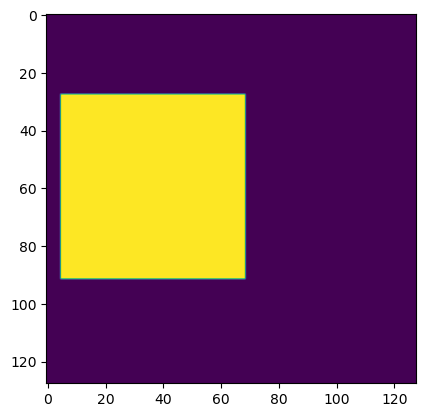

In [6]:
import matplotlib.pyplot as plt
mask = make_mask(128, 64, mask_type='square')
print(type(mask), mask.shape)
plt.imshow(mask.permute(1, 2, 0))

In [8]:
img = Image.open("celeba_filtered_outputs/original_0000.png").resize((128, 128)) 
print(type(img), img.size)

<class 'PIL.Image.Image'> (128, 128)


In [9]:
T = transforms.ToTensor()
new_img = T(img)
print(new_img.shape)
masked_img = new_img * (1 - mask)
print(masked_img.shape)

torch.Size([3, 128, 128])
torch.Size([3, 128, 128])


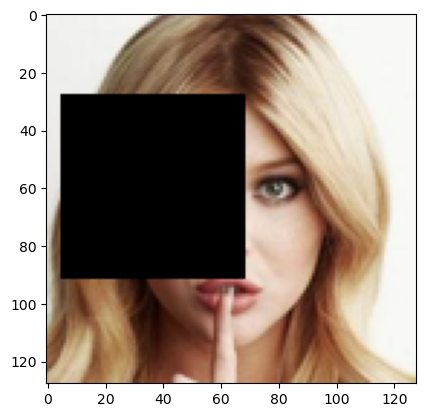

In [10]:
# masked_img.show()

plt.imshow(masked_img.permute(1, 2, 0))
# plt.imshow(new_img.permute(1, 2, 0))

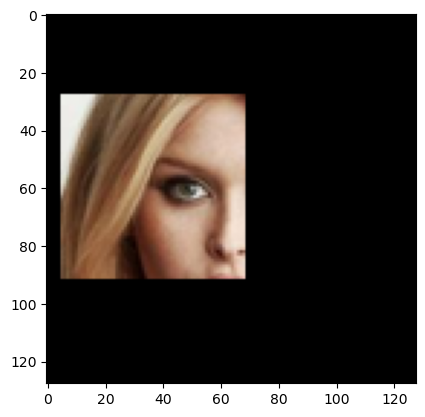

In [11]:
og_mask = new_img * mask
plt.imshow(og_mask.permute(1, 2, 0))